In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
import openpyxl

from matplotlib.colors import ListedColormap,Normalize,BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
data_path = os.path.join('C:\\','data')
output_path = os.path.join('C:\\','projects','pg_risk_analysis_output','output')
risk_path = os.path.join(output_path,'risk')
risk_path_scale = os.path.join(output_path,'output_without_scaling','risk')

figure_path = os.path.join('C:\\','projects','pg_risk_analysis_output','output','figures')

# Load datasets with additional information about countries to create the maps

In [3]:
ne_countries = gpd.read_file(os.path.join(data_path,'natural_earth','ne_10m_admin_0_countries.shp'))
ne_sindex = ne_countries.sindex

# Read and restructure risk results

In [4]:
def read_risk(hazard_type,infra_type,risk_path):
    """
    Read the risk results of historical (FL) and present (TC) climate model
    """
    outputs = {}
    for risk_output in os.listdir(risk_path):
        climate_model = os.path.splitext(risk_output)[0].split('_')[3]
        if (hazard_type in risk_output) & (infra_type in risk_output) & (climate_model in risk_output):
            check_sheets = pd.ExcelFile(os.path.join(risk_path,risk_output),engine='openpyxl').sheet_names
            for sheet in check_sheets:
                out = pd.read_excel(os.path.join(risk_path,risk_output),sheet_name= sheet, index_col=[0],engine='openpyxl')
                outputs[risk_output[:3],climate_model,sheet] = out
    df = pd.concat(outputs).unstack(level=2).dropna(axis=1, how='all')
    #df.to_csv(os.path.join(output_path,'{}_risk.csv'.format(hazard_type)))
    
    return df

In [5]:
def restructure_risk(hazard_type,infra_type,climate_model,risk_path):
    df = read_risk(hazard_type,infra_type,risk_path)
    
    if hazard_type == 'tc' and infra_type == 'osm':
        df = df.drop(['W3_1','W3_2','W3_3','W3_4','W3_5'],axis=1)
            
    # country_codes does not include Singapore, Mongolia
    country_codes = ['BRN','CHN','IDN','JPN','KHM','KOR','LAO','MMR','MYS','PHL','PRK','SGP','THA','TWN','VNM']
       
    reframe_risk = {}
    model_risk = {}
        
    for country_code in country_codes:
        reframe_risk[country_code] = df.unstack(level=-1).T.unstack(level=-1)[country_code]

        model_risk[country_code] = reframe_risk[country_code][climate_model].reset_index()
        model_risk[country_code] = model_risk[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
        model_risk[country_code]['country_code'] = country_code
        model_risk[country_code]['climate_model'] = climate_model
        model_risk[country_code]['infra_type'] = 'osm'

        df_risk_result = pd.concat(model_risk.values(), keys=model_risk.keys())
        risk_result = pd.concat([df_risk_result])
        
            
    return risk_result[['country_code','asset_type','mean_risk','lower_risk','upper_risk']]

In [6]:
restructure_risk('tc','osm','present',risk_path)

country_code       asset_type      mean_risk     lower_risk  \
BRN 0            BRN  substation_risk  329355.087823  247016.315867   
    1            BRN  substation_risk  203468.254255  152601.190691   
    2            BRN  substation_risk  109785.029274   82338.771956   
    3            BRN  substation_risk   69164.568443   51873.426332   
    4            BRN  substation_risk   58186.065515   43639.549136   
...              ...              ...            ...            ...   
VNM 200          VNM        pole_risk  296418.899046  222314.174284   
    201          VNM        pole_risk  295111.768537  221333.826402   
    202          VNM        pole_risk  295602.365005  221701.773754   
    203          VNM        pole_risk  296267.818266  222200.863700   
    204          VNM        pole_risk    2121.532542    1591.149407   

            upper_risk  
BRN 0    411693.859778  
    1    254335.317819  
    2    137231.286593  
    3     86455.710553  
    4     72732.581894  
...                ...  
VNM 200  370523.623807  
    201  368889.710671  
    202  369502.956256  
    203  370334.772833  
    204    2651.915678  

[3075 rows x 5 columns]

# Table 2

## Historical risk of tropical cyclone

In [7]:
# calculate FL osm hist median risk for each infrastructure type
df = restructure_risk('tc','osm','present',risk_path)

tc_hist_risk = pd.DataFrame(columns=['country_code','asset_type','median_risk'])

# Group df according to the country code and asset type, and calculate the median value of all median risks for each infrastructure type
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].median().reset_index()

tc_hist_risk['country_code'] = grouped_df['country_code']
tc_hist_risk['asset_type'] = grouped_df['asset_type']
tc_hist_risk['median_risk'] = grouped_df['mean_risk']
tc_hist_risk['climate_model'] = 'present'

tc_hist_risk

,country_code,asset_type,median_risk,climate_model
0,BRN,line_risk,NaN,present
1,BRN,pole_risk,NaN,present
2,BRN,substation_risk,5.598502e+04,present
3,BRN,tower_risk,NaN,present
4,CHN,line_risk,3.937056e+09,present
5,CHN,pole_risk,9.439358e+05,present
6,CHN,substation_risk,6.247995e+06,present
7,CHN,tower_risk,2.232670e+08,present
8,IDN,line_risk,9.259001e+07,present
9,IDN,pole_risk,3.799828e+04,present


In [8]:
# calculate FL osm hist sum risk for each country
sum_tc_hist_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])

grouped_tc_hist_risk = tc_hist_risk.groupby('country_code')['median_risk'].sum().reset_index()

sum_tc_hist_risk['country_code'] = grouped_tc_hist_risk['country_code']
sum_tc_hist_risk['sum_risk'] = grouped_tc_hist_risk['median_risk']
sum_tc_hist_risk['climate_model'] = tc_hist_risk.groupby('country_code')['climate_model'].first().values

sum_tc_hist_risk

,country_code,climate_model,sum_risk
0,BRN,present,5.598502e+04
1,CHN,present,4.167515e+09
2,IDN,present,1.084217e+08
3,JPN,present,8.916288e+09
4,KHM,present,4.542577e+06
5,KOR,present,1.312884e+09
6,LAO,present,3.077435e+07
7,MMR,present,1.046551e+07
8,MYS,present,3.799404e+07
9,PHL,present,1.475546e+08


## Future risk of tropical cyclone (4 climate models)

In [9]:
climate_models = ['CMCC-CM2-VHR4','CNRM-CM6-1-HR','EC-Earth3P-HR','HadGEM3-GC31-HM']

cmcc_risk = restructure_risk('tc','osm','CMCC-CM2-VHR4',risk_path)
cnrm_risk = restructure_risk('tc','osm','CNRM-CM6-1-HR',risk_path)
ec_risk = restructure_risk('tc','osm','EC-Earth3P-HR',risk_path)
had_risk = restructure_risk('tc','osm','HadGEM3-GC31-HM',risk_path)

In [10]:
# calculate TC osm median risk of each climate model for each infrastructure type
cmcc_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'median_risk'])
cnrm_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'median_risk'])
ec_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'median_risk'])
had_risk_new = pd.DataFrame(columns=['country_code', 'asset_type', 'median_risk'])

# Group df according to the country code and asset type, and calculate the median value of all median risks for each infrastructure type
grouped_cmcc_risk = cmcc_risk.groupby(['country_code', 'asset_type'])['mean_risk'].median().reset_index()
grouped_cnrm_risk = cnrm_risk.groupby(['country_code', 'asset_type'])['mean_risk'].median().reset_index()
grouped_ec_risk = ec_risk.groupby(['country_code', 'asset_type'])['mean_risk'].median().reset_index()
grouped_had_risk = had_risk.groupby(['country_code', 'asset_type'])['mean_risk'].median().reset_index()

cmcc_risk_new['country_code'] = grouped_cmcc_risk['country_code']
cmcc_risk_new['asset_type'] = grouped_cmcc_risk['asset_type']
cmcc_risk_new['median_risk'] = grouped_cmcc_risk['mean_risk']
cmcc_risk_new['climate_model'] = 'CMCC-CM2-VHR4'

cnrm_risk_new['country_code'] = grouped_cnrm_risk['country_code']
cnrm_risk_new['asset_type'] = grouped_cnrm_risk['asset_type']
cnrm_risk_new['median_risk'] = grouped_cnrm_risk['mean_risk']
cnrm_risk_new['climate_model'] = 'CNRM-CM6-1-HR'

ec_risk_new['country_code'] = grouped_ec_risk['country_code']
ec_risk_new['asset_type'] = grouped_ec_risk['asset_type']
ec_risk_new['median_risk'] = grouped_ec_risk['mean_risk']
ec_risk_new['climate_model'] = 'EC-Earth3P-HR'

had_risk_new['country_code'] = grouped_had_risk['country_code']
had_risk_new['asset_type'] = grouped_had_risk['asset_type']
had_risk_new['median_risk'] = grouped_had_risk['mean_risk']
had_risk_new['climate_model'] = 'HadGEM3-GC31-HM'

In [11]:
# calculate TC CMCC-CM2-VHR4 risk
sum_tc_cmcc_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])
grouped_tc_cmcc_risk = cmcc_risk_new.groupby('country_code')['median_risk'].sum().reset_index()
sum_tc_cmcc_risk['country_code'] = grouped_tc_cmcc_risk['country_code']
sum_tc_cmcc_risk['sum_risk'] = grouped_tc_cmcc_risk['median_risk']
sum_tc_cmcc_risk['climate_model'] = cmcc_risk_new.groupby('country_code')['climate_model'].first().values

# calculate TC CNRM-CM6-1-HR risk
sum_tc_cnrm_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])
grouped_tc_cnrm_risk = cnrm_risk_new.groupby('country_code')['median_risk'].sum().reset_index()
sum_tc_cnrm_risk['country_code'] = grouped_tc_cnrm_risk['country_code']
sum_tc_cnrm_risk['sum_risk'] = grouped_tc_cnrm_risk['median_risk']
sum_tc_cnrm_risk['climate_model'] = cnrm_risk_new.groupby('country_code')['climate_model'].first().values

# calculate TC EC-Earth3P-HR risk
sum_tc_ec_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])
grouped_tc_ec_risk = ec_risk_new.groupby('country_code')['median_risk'].sum().reset_index()
sum_tc_ec_risk['country_code'] = grouped_tc_ec_risk['country_code']
sum_tc_ec_risk['sum_risk'] = grouped_tc_ec_risk['median_risk']
sum_tc_ec_risk['climate_model'] = ec_risk_new.groupby('country_code')['climate_model'].first().values

# calculate TC HadGEM3-GC31-HM risk
sum_tc_had_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])
grouped_tc_had_risk = had_risk_new.groupby('country_code')['median_risk'].sum().reset_index()
sum_tc_had_risk['country_code'] = grouped_tc_had_risk['country_code']
sum_tc_had_risk['sum_risk'] = grouped_tc_had_risk['median_risk']
sum_tc_had_risk['climate_model'] = had_risk_new.groupby('country_code')['climate_model'].first().values

In [12]:
# calculate TC osm future median risk for each infrastructure type (median risk of four climate models)
df = pd.concat([cmcc_risk_new,cnrm_risk_new,ec_risk_new,had_risk_new], axis=0)
grouped_df = df.groupby(['country_code', 'asset_type'])['median_risk'].median().reset_index()

tc_future_risk = pd.DataFrame(columns=['country_code', 'asset_type', 'median_risk'])

tc_future_risk['country_code'] = grouped_df['country_code']
tc_future_risk['asset_type'] = grouped_df['asset_type']
tc_future_risk['median_risk'] = grouped_df['median_risk']
tc_future_risk['climate_model'] = 'future'
tc_future_risk

,country_code,asset_type,median_risk,climate_model
0,BRN,line_risk,NaN,future
1,BRN,pole_risk,NaN,future
2,BRN,substation_risk,5.157981e+04,future
3,BRN,tower_risk,NaN,future
4,CHN,line_risk,5.706023e+09,future
5,CHN,pole_risk,6.604765e+05,future
6,CHN,substation_risk,1.232837e+07,future
7,CHN,tower_risk,3.281773e+08,future
8,IDN,line_risk,1.409325e+08,future
9,IDN,pole_risk,9.211384e+04,future


In [13]:
# calculate TC future sum risk for each country
sum_tc_future_risk = pd.DataFrame(columns=['country_code', 'climate_model', 'sum_risk'])

grouped_tc_future_risk = tc_future_risk.groupby('country_code')['median_risk'].sum().reset_index()

sum_tc_future_risk['country_code'] = grouped_tc_future_risk['country_code']
sum_tc_future_risk['sum_risk'] = grouped_tc_future_risk['median_risk']
sum_tc_future_risk['climate_model'] = tc_future_risk.groupby('country_code')['climate_model'].first().values

sum_tc_future_risk

,country_code,climate_model,sum_risk
0,BRN,future,5.157981e+04
1,CHN,future,6.047190e+09
2,IDN,future,1.593032e+08
3,JPN,future,1.287318e+10
4,KHM,future,6.140141e+06
5,KOR,future,2.134642e+09
6,LAO,future,3.773235e+07
7,MMR,future,1.185026e+07
8,MYS,future,9.325820e+07
9,PHL,future,1.651836e+08


In [14]:
# Assemble tc risks
tc_risk = pd.concat([sum_tc_hist_risk,sum_tc_cmcc_risk,sum_tc_cnrm_risk,sum_tc_ec_risk,sum_tc_had_risk,sum_tc_future_risk],axis=1)

tc_risk.columns.values[2]='Present'
tc_risk.columns.values[5]='CMCC-CM2-VHR4'
tc_risk.columns.values[8]='CNRM-CM6-1-HR'
tc_risk.columns.values[11]='EC-Earth3P-HR'
tc_risk.columns.values[14]='HadGEM3-GC31-HM'
tc_risk.columns.values[17]='Median risk of climate models'

tc_risk = tc_risk.drop(tc_risk.columns[[3,4,6,7,9,10,12,13,15,16]], axis=1)

tc_risk.insert(0,'country_code',['BRN','CHN','IDN','JPN','KHM','KOR','LAO','MMR','MYS','PHL','PRK','SGP','THA','TWN','VNM'])
#tc_risk = tc_risk.set_index('country_code')

tc_risk['CMCC-CM2-VHR4 change ratio (%)'] = (tc_risk['CMCC-CM2-VHR4'] - tc_risk['Present']) / tc_risk['Present'] * 100
tc_risk['CNRM-CM6-1-HR change ratio (%)'] = (tc_risk['CNRM-CM6-1-HR'] - tc_risk['Present']) / tc_risk['Present'] * 100
tc_risk['EC-Earth3P-HR change ratio (%)'] = (tc_risk['EC-Earth3P-HR'] - tc_risk['Present']) / tc_risk['Present'] * 100
tc_risk['HadGEM3-GC31-HM change ratio (%)'] = (tc_risk['HadGEM3-GC31-HM'] - tc_risk['Present']) / tc_risk['Present'] * 100
tc_risk['Median risk change ratio (%)'] = (tc_risk['Median risk of climate models'] - tc_risk['Present']) / tc_risk['Present'] * 100
tc_risk

,country_code,Present,CMCC-CM2-VHR4,CNRM-CM6-1-HR,EC-Earth3P-HR,HadGEM3-GC31-HM,Median risk of climate models,CMCC-CM2-VHR4 change ratio (%),CNRM-CM6-1-HR change ratio (%),EC-Earth3P-HR change ratio (%),HadGEM3-GC31-HM change ratio (%),Median risk change ratio (%)
0,BRN,5.598502e+04,5.153799e+04,5.574587e+04,5.112423e+04,5.162164e+04,5.157981e+04,-7.943249,-0.427158,-8.682303,-7.793834,-7.868542
1,CHN,4.167515e+09,5.339390e+09,6.150341e+09,5.944038e+09,6.576538e+09,6.047190e+09,28.119271,47.578122,42.627872,57.804764,45.102997
2,IDN,1.084217e+08,1.600092e+08,1.591909e+08,1.591963e+08,1.593050e+08,1.593032e+08,47.580476,46.825747,46.830721,46.930926,46.929317
3,JPN,8.916288e+09,1.188590e+10,1.264524e+10,1.310113e+10,1.473898e+10,1.287318e+10,33.305480,41.821762,46.934823,65.304052,44.378293
4,KHM,4.542577e+06,6.186190e+06,6.094073e+06,6.069618e+06,6.245769e+06,6.140141e+06,36.182413,34.154549,33.616203,37.493979,35.168696
5,KOR,1.312884e+09,1.914733e+09,2.132636e+09,2.136649e+09,2.373003e+09,2.134642e+09,45.841695,62.438938,62.744601,80.747306,62.591770
6,LAO,3.077435e+07,3.806111e+07,3.800717e+07,3.733839e+07,3.745789e+07,3.773235e+07,23.678038,23.502752,21.329602,21.717891,22.609751
7,MMR,1.046551e+07,1.288405e+07,1.130222e+07,1.180881e+07,1.191375e+07,1.185026e+07,23.109621,7.994951,12.835481,13.838212,13.231528
8,MYS,3.799404e+07,9.327380e+07,9.289116e+07,9.347353e+07,9.325056e+07,9.325820e+07,145.495897,144.488778,146.021579,145.434731,145.454831
9,PHL,1.475546e+08,1.569333e+08,1.719864e+08,1.633587e+08,1.670085e+08,1.651836e+08,6.356126,16.557866,10.710690,13.184269,11.947480


## Historical risk of coastal flood (with GDP per capita scaling)

In [15]:
# calculate FL osm hist median risk for each infrastructure type
df = restructure_risk('fl','osm','historical',risk_path)

fl_hist_risk = pd.DataFrame(columns=['country_code','asset_type','median_risk'])

# Group df according to the country code and asset type, and calculate the median value of all median risks for each infrastructure type
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].median().reset_index()

fl_hist_risk['country_code'] = grouped_df['country_code']
fl_hist_risk['asset_type'] = grouped_df['asset_type']
fl_hist_risk['median_risk'] = grouped_df['mean_risk']
fl_hist_risk['climate_model'] = 'historical'

fl_hist_risk

,country_code,asset_type,median_risk,climate_model
0,BRN,line_risk,NaN,historical
1,BRN,plant_risk,NaN,historical
2,BRN,pole_risk,NaN,historical
3,BRN,substation_risk,NaN,historical
4,BRN,tower_risk,NaN,historical
...,...,...,...,...
70,VNM,line_risk,4.731586e+04,historical
71,VNM,plant_risk,2.268580e+07,historical
72,VNM,pole_risk,NaN,historical
73,VNM,substation_risk,1.229517e+03,historical


In [16]:
# calculate FL osm hist sum risk for each country
sum_fl_hist_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])

grouped_fl_hist_risk = fl_hist_risk.groupby('country_code')['median_risk'].sum().reset_index()

sum_fl_hist_risk['country_code'] = grouped_fl_hist_risk['country_code']
sum_fl_hist_risk['sum_risk'] = grouped_fl_hist_risk['median_risk']
sum_fl_hist_risk['climate_model'] = fl_hist_risk.groupby('country_code')['climate_model'].first().values

sum_fl_hist_risk

,country_code,climate_model,sum_risk
0,BRN,historical,0.000000e+00
1,CHN,historical,1.226481e+09
2,IDN,historical,4.140717e+07
3,JPN,historical,2.166450e+09
4,KHM,historical,0.000000e+00
5,KOR,historical,4.717015e+08
6,LAO,historical,0.000000e+00
7,MMR,historical,7.425094e+04
8,MYS,historical,1.268874e+07
9,PHL,historical,1.296644e+06


## Future risk of coastal flood (with GDP per capita scaling)

In [17]:
# calculate FL osm rcp median risk for each infrastructure type
df = restructure_risk('fl','osm','rcp8p5',risk_path)[['country_code','asset_type','mean_risk']]

fl_rcp_risk = pd.DataFrame(columns=['country_code', 'asset_type', 'median_risk'])

# Group df according to the country code and asset type, and calculate the median value of all median risks for each infrastructure type
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].median().reset_index()

fl_rcp_risk['country_code'] = grouped_df['country_code']
fl_rcp_risk['asset_type'] = grouped_df['asset_type']
fl_rcp_risk['median_risk'] = grouped_df['mean_risk']
fl_rcp_risk['climate_model'] = 'rcp8p5'

fl_rcp_risk

,country_code,asset_type,median_risk,climate_model
0,BRN,line_risk,NaN,rcp8p5
1,BRN,plant_risk,NaN,rcp8p5
2,BRN,pole_risk,NaN,rcp8p5
3,BRN,substation_risk,NaN,rcp8p5
4,BRN,tower_risk,NaN,rcp8p5
...,...,...,...,...
70,VNM,line_risk,6.181825e+04,rcp8p5
71,VNM,plant_risk,2.655209e+07,rcp8p5
72,VNM,pole_risk,NaN,rcp8p5
73,VNM,substation_risk,2.280863e+03,rcp8p5


In [18]:
# calculate FL fl rcp sum risk for each country
sum_fl_rcp_risk = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])

grouped_fl_rcp_risk = fl_rcp_risk.groupby('country_code')['median_risk'].sum().reset_index()

sum_fl_rcp_risk['country_code'] = grouped_fl_rcp_risk['country_code']
sum_fl_rcp_risk['sum_risk'] = grouped_fl_rcp_risk['median_risk']

sum_fl_rcp_risk['climate_model'] = fl_rcp_risk.groupby('country_code')['climate_model'].first().values

sum_fl_rcp_risk

,country_code,climate_model,sum_risk
0,BRN,rcp8p5,0.000000e+00
1,CHN,rcp8p5,1.247328e+09
2,IDN,rcp8p5,4.324741e+07
3,JPN,rcp8p5,2.068920e+09
4,KHM,rcp8p5,0.000000e+00
5,KOR,rcp8p5,4.712617e+08
6,LAO,rcp8p5,0.000000e+00
7,MMR,rcp8p5,1.161643e+05
8,MYS,rcp8p5,1.235040e+07
9,PHL,rcp8p5,1.539495e+06


In [19]:
# Assemble fl risks
fl_risk = pd.concat([sum_fl_hist_risk,sum_fl_rcp_risk],axis=1)

fl_risk.columns.values[2]='Historical'
fl_risk.columns.values[5]='RCP8.5'

fl_risk = fl_risk.drop(fl_risk.columns[[3,4]], axis=1)

fl_risk.insert(0,'country_code',['BRN','CHN','IDN','JPN','KHM','KOR','LAO','MMR','MYS','PHL','PRK','SGP','THA','TWN','VNM'])
#fl_risk = fl_risk.set_index('country_code')

fl_risk['Change ratio (%)'] = (fl_risk['RCP8.5'] - fl_risk['Historical']) / fl_risk['Historical'] * 100
fl_risk

,country_code,Historical,RCP8.5,Change ratio (%)
0,BRN,0.000000e+00,0.000000e+00,NaN
1,CHN,1.226481e+09,1.247328e+09,1.699724
2,IDN,4.140717e+07,4.324741e+07,4.444240
3,JPN,2.166450e+09,2.068920e+09,-4.501834
4,KHM,0.000000e+00,0.000000e+00,NaN
5,KOR,4.717015e+08,4.712617e+08,-0.093237
6,LAO,0.000000e+00,0.000000e+00,NaN
7,MMR,7.425094e+04,1.161643e+05,56.448293
8,MYS,1.268874e+07,1.235040e+07,-2.666426
9,PHL,1.296644e+06,1.539495e+06,18.729150


# Table S5: Historical risk of coastal flood (without GDP per capita scaling)

In [20]:
# Risk estimation without GDP per capita scaling
# calculate FL osm hist median risk for each infrastructure type
df = restructure_risk('fl','osm','historical',risk_path_scale)

fl_without_scale = pd.DataFrame(columns=['country_code','asset_type','median_risk'])

# Group df according to the country code and asset type, and calculate the median value of all median risks for each infrastructure type
grouped_df = df.groupby(['country_code', 'asset_type'])['mean_risk'].median().reset_index()

fl_without_scale['country_code'] = grouped_df['country_code']
fl_without_scale['asset_type'] = grouped_df['asset_type']
fl_without_scale['median_risk'] = grouped_df['mean_risk']

fl_without_scale['climate_model'] = 'historical'

# calculate FL osm hist sum risk for each country
sum_fl_without_scale = pd.DataFrame(columns=['country_code','climate_model','sum_risk'])

grouped_fl_without_scale = fl_without_scale.groupby('country_code')['median_risk'].sum().reset_index()

sum_fl_without_scale['country_code'] = grouped_fl_without_scale['country_code']
sum_fl_without_scale['sum_risk'] = grouped_fl_without_scale['median_risk']
sum_fl_without_scale['climate_model'] = fl_without_scale.groupby('country_code')['climate_model'].first().values

sum_fl_without_scale

,country_code,climate_model,sum_risk
0,BRN,historical,0.000000e+00
1,CHN,historical,6.921449e+09
2,IDN,historical,6.399872e+08
3,JPN,historical,3.664496e+09
4,KHM,historical,0.000000e+00
5,KOR,historical,8.788923e+08
6,LAO,historical,0.000000e+00
7,MMR,historical,2.690251e+06
8,MYS,historical,7.148585e+07
9,PHL,historical,2.370465e+07


In [21]:
sum_fl_without_scale.to_excel(os.path.join(figure_path,'Table S5_FL country risk (without GDP scaling).xlsx'),index=False)

## Create Table 2 of country risk

In [23]:
multi_risk = pd.concat([tc_risk.iloc[:,1:7], fl_risk.iloc[:,1:3]],axis=1)
multi_risk.insert(0,'Country',['Brunei','China','Indonesia','Japan','Cambodia','South Korea','Laos','Myanmar',
                               'Malaysia','Philippines','North Korea','Singapore','Thailand','Taiwan','Vietnam'])

multi_risk.to_excel(os.path.join(figure_path,'Table 2_TC&FL country risk.xlsx'),index=False)

# Figue S1: Creat heatmaps

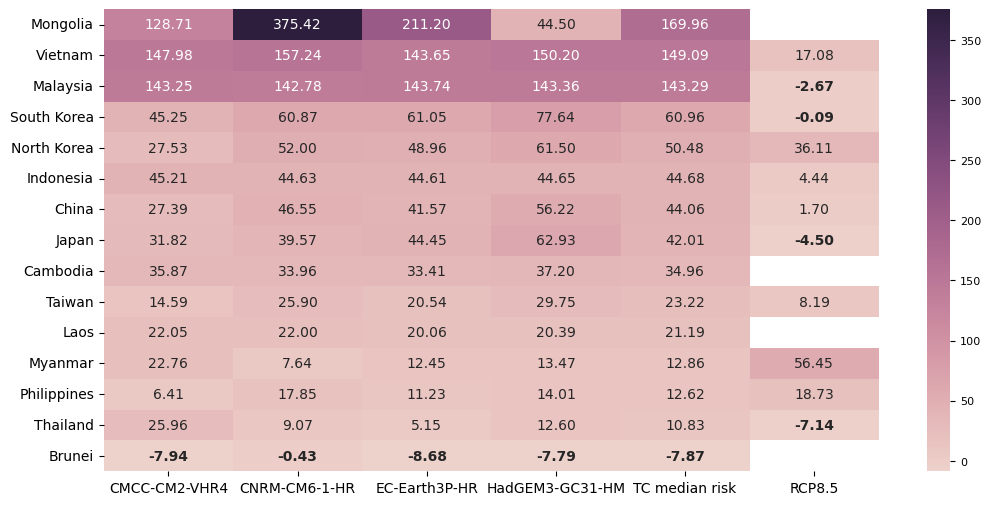

In [96]:
tc_change = tc_risk[['CMCC-CM2-VHR4 change ratio (%)','CNRM-CM6-1-HR change ratio (%)',
                   'EC-Earth3P-HR change ratio (%)','HadGEM3-GC31-HM change ratio (%)',
                   'Median risk change ratio (%)']]
tc_change = tc_change.rename(columns={
    'CMCC-CM2-VHR4 change ratio (%)': 'CMCC-CM2-VHR4',
    'CNRM-CM6-1-HR change ratio (%)': 'CNRM-CM6-1-HR',
    'EC-Earth3P-HR change ratio (%)': 'EC-Earth3P-HR',
    'HadGEM3-GC31-HM change ratio (%)': 'HadGEM3-GC31-HM',
    'Median risk change ratio (%)': 'TC median risk'})

fl_change = fl_risk[['Change ratio (%)']]
fl_change = fl_change.rename(columns={'Change ratio (%)': 'RCP8.5'})

multi_change = pd.concat([tc_change,fl_change],axis=1)
multi_change.insert(0,'Country',['Brunei','China','Indonesia','Japan','Cambodia','South Korea','Laos','Myanmar','Mongolia',
                                 'Malaysia','Philippines','North Korea','Singapore','Thailand','Taiwan','Vietnam'])
multi_change = multi_change.set_index('Country')
multi_change = multi_change.sort_values('TC median risk', ascending=False)
multi_change = multi_change.drop('Singapore', axis=0)

fig, ax = plt.subplots(figsize=(12.5,6))

heatmap = sns.heatmap(data=multi_change,cmap=sns.cubehelix_palette(as_cmap=True),annot=True,fmt='.2f') #delete countries without risk

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)

heatmap.set_xticklabels(multi_change.columns,rotation=0,ha='center',fontsize=10)
heatmap.set_ylabel(None)

for text in heatmap.texts:
    value = float(text.get_text())
    if value < 0:
        text.set_weight('bold')

plt.savefig(os.path.join(figure_path,'Figure 5_TC&FL heatmap.jpg'),dpi=450,bbox_inches='tight')

plt.show()

<class 'pandas.core.frame.DataFrame'>


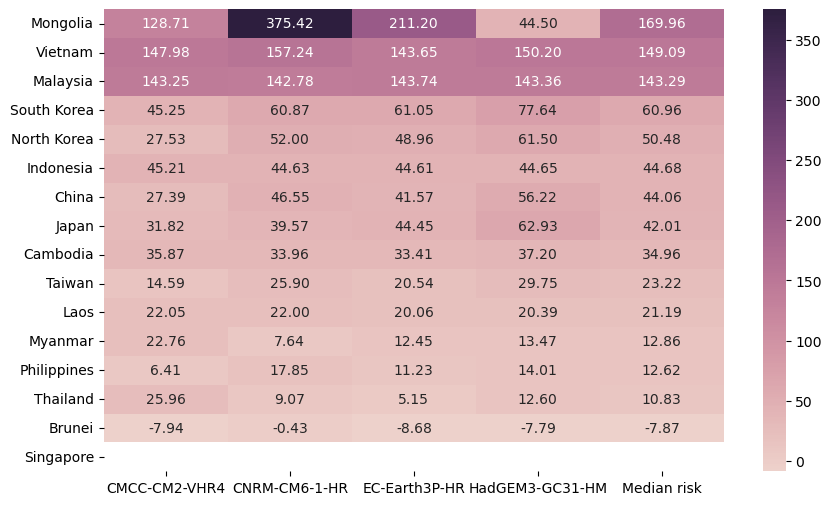

In [83]:
tc_change = tc_risk[['CMCC-CM2-VHR4 change ratio (%)','CNRM-CM6-1-HR change ratio (%)',
                   'EC-Earth3P-HR change ratio (%)','HadGEM3-GC31-HM change ratio (%)',
                   'Median risk change ratio (%)']]

tc_change = tc_change.rename(columns={
    'CMCC-CM2-VHR4 change ratio (%)': 'CMCC-CM2-VHR4',
    'CNRM-CM6-1-HR change ratio (%)': 'CNRM-CM6-1-HR',
    'EC-Earth3P-HR change ratio (%)': 'EC-Earth3P-HR',
    'HadGEM3-GC31-HM change ratio (%)': 'HadGEM3-GC31-HM',
    'Median risk change ratio (%)': 'Median risk'})

tc_change.insert(0,'Country',['Brunei','China','Indonesia','Japan','Cambodia','South Korea','Laos','Myanmar','Mongolia',
                                    'Malaysia','Philippines','North Korea','Singapore','Thailand','Taiwan','Vietnam'])

tc_change = tc_change.set_index('Country')

tc_change = tc_change.sort_values('Median risk', ascending=False)

fig, ax = plt.subplots(figsize=(10,6))

heatmap = sns.heatmap(data=tc_change,cmap=sns.cubehelix_palette(as_cmap=True),annot=True,fmt='.2f') #data=tc_change.dropna() #delete countries without risk

heatmap.set_xticklabels(tc_change.columns,rotation=0,ha='center',fontsize=10)
heatmap.set_ylabel(None)

plt.savefig(os.path.join(figure_path,'Figure 5(a)_TC heatmap.jpg'),dpi=450,bbox_inches='tight')

plt.show()

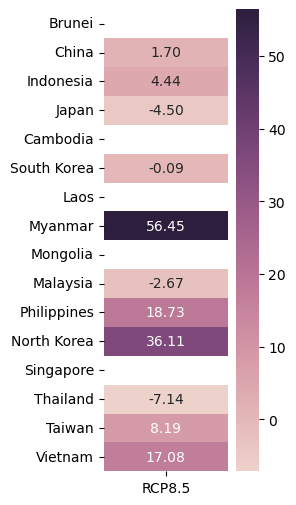

In [84]:
fl_change = fl_risk[['Change ratio (%)']]
fl_change = fl_change.rename(columns={'Change ratio (%)': 'RCP8.5'})

fl_change.insert(0,'Country',['Brunei','China','Indonesia','Japan','Cambodia','South Korea','Laos','Myanmar','Mongolia',
                                    'Malaysia','Philippines','North Korea','Singapore','Thailand','Taiwan','Vietnam'])

fl_change = fl_change.set_index('Country')

#fl_change = fl_change.sort_values('Median risk', ascending=False)

fig, ax = plt.subplots(figsize=(2,6))

heatmap = sns.heatmap(data=fl_change,cmap=sns.cubehelix_palette(as_cmap=True),annot=True,fmt='.2f')

heatmap.set_xticklabels(fl_change.columns,rotation=0,ha='center',fontsize=10)
heatmap.set_ylabel(None)

plt.savefig(os.path.join(figure_path,'Figure 5(b)_FL heatmap.jpg'),dpi=450,bbox_inches='tight')

plt.show()

# Create maps based on sum risk

In [136]:
# 根据country_code将数据框与地图数据合并
fl_hist = ne_countries.merge(sum_fl_hist_risk, left_on='SOV_A3', right_on='country_code', how='right')
fl_future = ne_countries.merge(sum_fl_rcp_risk, left_on='SOV_A3', right_on='country_code', how='right')
tc_hist = ne_countries.merge(sum_tc_hist_risk, left_on='SOV_A3', right_on='country_code', how='right')
tc_future = ne_countries.merge(sum_tc_future_risk, left_on='SOV_A3', right_on='country_code', how='right')

In [137]:
fl_future

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,country_code,climate_model,sum_risk
0,Admin-0 country,0,6,Brunei,BRN,0,2,Sovereign country,1,Brunei,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((115.14617 4.90851, 115.14680 4...",BRN,rcp8p5,0.000000e+00
1,Admin-0 country,0,2,China,CHN,1,2,Country,1,China,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((78.91769 33.38626, 78.91595 33...",CHN,rcp8p5,9.163142e+08
2,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",IDN,rcp8p5,3.286435e+07
3,Admin-0 country,0,2,Japan,JPN,0,2,Sovereign country,1,Japan,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((129.78321 31.79963, 129.79086 ...",JPN,rcp8p5,1.518070e+09
4,Admin-0 country,0,3,Cambodia,KHM,0,2,Sovereign country,1,Cambodia,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((107.52039 14.70458, 107.53243 ...",KHM,rcp8p5,0.000000e+00
5,Admin-0 country,0,2,South Korea,KOR,0,2,Sovereign country,1,South Korea,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((128.36492 38.62434, 128.39478 ...",KOR,rcp8p5,3.494443e+08
6,Admin-0 country,0,4,Laos,LAO,0,2,Sovereign country,1,Laos,...,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((102.11866 22.39755, 102.12542 22.383...",LAO,rcp8p5,0.000000e+00
7,Admin-0 country,0,3,Myanmar,MMR,0,2,Sovereign country,1,Myanmar,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((92.57588 21.97757, 92.58384 21...",MMR,rcp8p5,8.514797e+04
8,Admin-0 country,0,3,Mongolia,MNG,0,2,Sovereign country,1,Mongolia,...,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.68428 49.82326, 116.47292 49.516...",MNG,rcp8p5,0.000000e+00
9,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",MYS,rcp8p5,9.078306e+06


C:\Users\mye500\AppData\Local\Temp\ipykernel_43400\1605836698.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


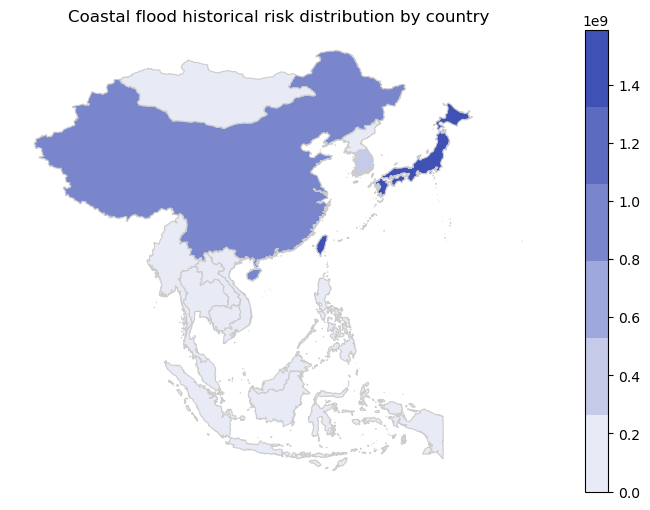

In [138]:
# With normalization
cmap = ListedColormap(['#E8EAF6', '#C5CAE9', '#9FA8DA', '#7986CB', '#5C6BC0', '#3F51B5'])
min_val = fl_hist['sum_risk'].min()
max_val = fl_hist['sum_risk'].max()
norm = Normalize(vmin=min_val, vmax=max_val)

fig, ax = plt.subplots(figsize=(10, 6))
fl_hist.plot(column='sum_risk', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', norm=norm)

ax.set_title('Coastal flood historical risk distribution by country')
ax.set_axis_off()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm)

plt.show()

In [129]:
# calculate relative change of risk
relative_change = ((fl_future.groupby('country_code')['sum_risk'].sum() - fl_hist.groupby('country_code')['sum_risk'].sum())
    / fl_hist.groupby('country_code')['sum_risk'].sum()) * 100

relative_risk = pd.DataFrame({
    'country_code': relative_change.index,
    'relative_change': relative_change.values
})

   country_code  relative_change
0           BRN              NaN
1           CHN         1.705025
2           IDN         4.072803
3           JPN        -4.493193
4           KHM              NaN
5           KOR        -0.071896
6           LAO              NaN
7           MMR        56.449489
8           MNG              NaN
9           MYS        -2.647328
10          PHL        18.730491
11          PRK        36.110998
12          THA        -7.134854
13          TWN         8.204428
14          VNM        17.097631


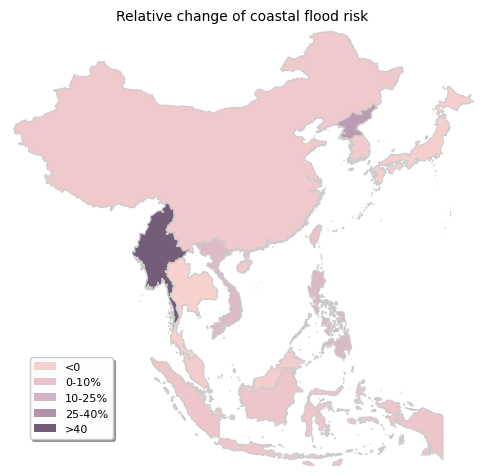

In [217]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

fl_change_map = ne_countries.merge(relative_risk, left_on='SOV_A3', right_on='country_code', how='right')

fig, ax = plt.subplots(figsize=(6,6))

labels = [0,1,2,3,4,5]
label_names = ['<0','0-10%','10-25%','25-40%','>40']
color_scheme = ['#F7D1CD', '#E8C2CA', '#D1B3C4', '#B392AC', '#735D78']
#color_scheme =  ['#F6F6F7','#F2D7EE','#D3BCC0','#A5668B','#69306D','#0E103D']

cmap = LinearSegmentedColormap.from_list(name='continents',colors=color_scheme)
bins = [-10,0,10,20,40]

legend_elements = [Patch(facecolor=color_scheme[0],label=label_names[0]),
                   Patch(facecolor=color_scheme[1],label=label_names[1]),
                   Patch(facecolor=color_scheme[2],label=label_names[2]),
                   Patch(facecolor=color_scheme[3],label=label_names[3]),
                   Patch(facecolor=color_scheme[4],label=label_names[4])]
                   
legend = ax.legend(handles=legend_elements,shadow=True,fancybox=True,facecolor='#fefdfd',prop={'size':8},
                   loc='lower left',bbox_to_anchor=(0.03,0.05, 0.5, 0.5))

fl_change_map.plot(column='relative_change', linewidth=0.8, ax=ax, edgecolor='0.8', cmap=cmap) #, norm=norm

ax.set_title('Relative change of coastal flood risk',fontsize=10)
ax.set_axis_off()

ax.set_xlim(73,146)
ax.set_ylim(-10,54)

plt.show()
